In [1]:
import os
import datetime
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Reshape

# Load & Preprocess Data

In [ ]:
dataset_X = []
dataset_y = []

data_path = "Data/"

output_data_folder_path = "Data/Output/"
output_model_folder_path = "Model/"

if not os.path.exists(output_data_folder_path):
    os.makedirs(output_data_folder_path)

if not os.path.exists(output_model_folder_path):
    os.makedirs(output_model_folder_path)

input_data_feature = data_path + "Final_Mesonet_Dataset.csv"

# Load data from csv
data = pd.read_csv(input_data_feature)

# Features model will predict
temperature_features = ['AirT_1pt5m', 'AirT_2m', 'AirT_9pt5m', 'AirT_10m']
humidity_features = ['RH_2m', 'RH_10m']
pressure_features = ['Pressure_1', 'Pressure_2']

dataset_X = data[temperature_features + humidity_features + pressure_features].values
dataset_y = data[temperature_features + humidity_features + pressure_features].values

# Traditional ML Model: Random Forest

In [ ]:
# Scale the data
scaler = MinMaxScaler()
dataset_X = scaler.fit_transform(dataset_X)
dataset_y = scaler.fit_transform(dataset_y)

# Chunk data into hours
window_size = 360  # 6 hours (360 minutes)
target_size = 60   # 1 hour (60 minutes)

x, y = [], []

# Create sliding window for input-output pairs
for i in range(0, len(dataset_X) - window_size - target_size + 1, window_size):
    x.append(dataset_X[i:i+window_size])  # Range: [i, i + 360] (Gets the 6 hours to predict results off of)
    y.append(dataset_y[i+window_size:i+window_size+target_size])  # Range: [i + 360, i + 360 + 60] (basically gets the hour after the given 6 hours)

x = np.array(x)  # Shape: (n_samples, 360, n_features)
y = np.array(y)  # Shape: (n_samples, 60, n_targets)

# Reshape for Random Forest (3D flattened to 2D input)
x = x.reshape((x.shape[0], -1))  
y = y.reshape((y.shape[0], -1))

# Split data (maintain sequential order, no shuffle)
split_index = int(len(x) * 0.8)  # 80% training, 20% testing
data_train, data_test = x[:split_index], x[split_index:]
labels_train, labels_test = y[:split_index], y[split_index:]

Test Mean Squared Error (MSE): 0.020035604604939725
Test Mean Absolute Error (MAE): 0.10445622972331575
Test R-squared (R²): -0.4891809705942266
Test Root Mean Squared Error (RMSE): 0.14154718155067492


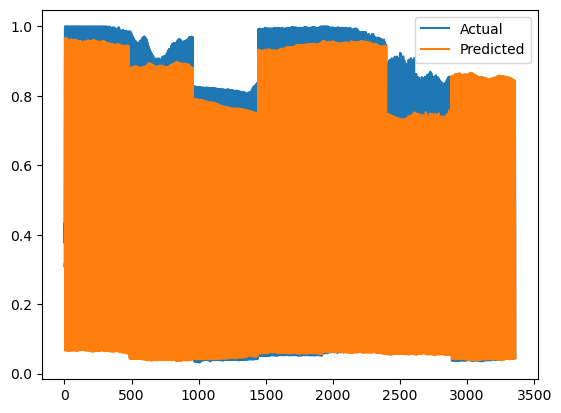

In [ ]:
# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(data_train, labels_train)

# Predict on the test set
test_predictions = model.predict(data_test)

# Calculate evaluation metrics
mse = mean_squared_error(labels_test, test_predictions)
mae = mean_absolute_error(labels_test, test_predictions)
r2 = r2_score(labels_test, test_predictions)
rmse = np.sqrt(mse)

# Print metrics
print("Test Mean Squared Error (MSE):", mse)
print("Test Mean Absolute Error (MAE):", mae)
print("Test R-squared (R²):", r2)
print("Test Root Mean Squared Error (RMSE):", rmse)

# Plot graph showing difference between predicted vs actual values
plt.plot(labels_test.flatten(), label="Actual")
plt.plot(test_predictions.flatten(), label="Predicted")
plt.legend()
plt.show()

# Save trained Random Forest model
save_model_path = output_model_folder_path + "rf_model.p"
pickle.dump(model, open(save_model_path, "wb"))

# Save dataset
save_data_path = output_data_folder_path + "dataset.p"
pickle.dump([data_train, labels_train], open(save_data_path, "wb"))

In [ ]:
# Loading saved Random Forest model
output_data_folder_path = "Label/All/"
output_model_folder_path = "Model/"

load_model_path = output_model_folder_path + "rf_model.p"
loaded_model = pickle.load(open(load_model_path, "rb"))

load_data_path = output_data_folder_path + "dataset.p"
dataset_X, dataset_y = pickle.load(open(load_data_path, "rb"))

# LSTM Model

In [5]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_X)

# Chunks data & returns array
def create_dataset(dataset, time_step=720, forecast=180):
    X, Y = [], []
    for i in range(len(dataset) - time_step - forecast + 1):
        # Get the data for the last 12 hours (720 rows) as input features
        X.append(dataset[i:(i + time_step)])
        # The target is the next 3 hours (180 rows) of weather data
        Y.append(dataset[(i + time_step):(i + time_step + forecast)])
    return np.array(X), np.array(Y)

# Call function to create datasets with given window size of 12 hours (720 rows)
X, y = create_dataset(dataset_X)  # Using feature data for input
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build LSTM model
model = Sequential()

# First LSTM layer with 50 units, returning sequences for stacking
model.add(LSTM(50, return_sequences=True, input_shape=(720, X_train.shape[2])))

# Additional LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))

# Final LSTM layer without returning sequences
model.add(LSTM(50, return_sequences=False))

# Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dense(25))

# Output layer with number of neurons matching forecast (180 time steps, 8 features)
output_features = len(temperature_features + humidity_features + pressure_features)  # 8 features
model.add(Dense(180 * output_features))  # Flatten output into 180 time steps for each feature

# Reshape output to match expected shape [batch_size, time_steps, features]
model.add(Reshape((180, output_features)))  # Reshape to [batch_size, 180, 8]

# Compile model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

/opt/anaconda3/envs/cisc484/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def run_results(optimizer, learn_rate):
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_error", "mean_squared_error", rmse],
    )

    # Train the model
    num_epochs = 25
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=num_epochs,
        batch_size=64,
        verbose=1,
    )

    # Predictions for training & testing
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Reshape predictions to 2D (samples, features) before inverse transforming
    train_predict2 = train_predict.reshape(-1, train_predict.shape[-1])
    test_predict2 = test_predict.reshape(-1, test_predict.shape[-1])

    # Inverse transformation to bring predictions back to original scale
    train_predict = scaler.inverse_transform(train_predict2)
    test_predict = scaler.inverse_transform(test_predict2)

    history.history.keys()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot training & validation MAE values
    ax1.plot(
        range(num_epochs), history.history["mean_absolute_error"], label="train_mae"
    )
    ax1.plot(
        range(num_epochs),
        history.history["val_mean_absolute_error"],
        label="validation_mae",
    )
    ax1.set_title("Training and validation MAE")
    ax1.set_ylabel("MAE")
    ax1.set_xlabel("Epochs")
    ax1.legend()

    # Plot training & validation MSE values
    ax2.plot(
        range(num_epochs), history.history["mean_squared_error"], label="train_mse"
    )
    ax2.plot(
        range(num_epochs),
        history.history["val_mean_squared_error"],
        label="validation_mse",
    )
    ax2.set_title("Training and validation MSE")
    ax2.set_ylabel("MSE")
    ax2.set_xlabel("Epochs")
    ax2.legend()

    fig.tight_layout()
    plt.title('{optimizer} with Learning Rate  {learn_rate}')
    plt.show()

    fig.savefig(f"numEpochs_{num_epochs}-learningRate_{learn_rate}.png")

Epoch 1/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - loss: 0.1382 - mean_absolute_error: 0.2757 - mean_squared_error: 0.1382 - rmse: 0.3423 - val_loss: 0.0465 - val_mean_absolute_error: 0.1690 - val_mean_squared_error: 0.0465 - val_rmse: 0.2152
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.0454 - mean_absolute_error: 0.1647 - mean_squared_error: 0.0454 - rmse: 0.2128 - val_loss: 0.0565 - val_mean_absolute_error: 0.1865 - val_mean_squared_error: 0.0565 - val_rmse: 0.2374
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.0432 - mean_absolute_error: 0.1604 - mean_squared_error: 0.0432 - rmse: 0.2076 - val_loss: 0.0580 - val_mean_absolute_error: 0.1889 - val_mean_squared_error: 0.0580 - val_rmse: 0.2406
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.0412 - mean_absolute_error: 0.1565 - mean_squared_error: 0.0412 - rmse: 0.2026 - val_loss: 0.0360 - val_mean_absolute_error: 0.1476 - val_mean_squared_error: 0.0360 - val_rmse: 0.1895
Epoch 5/25
1

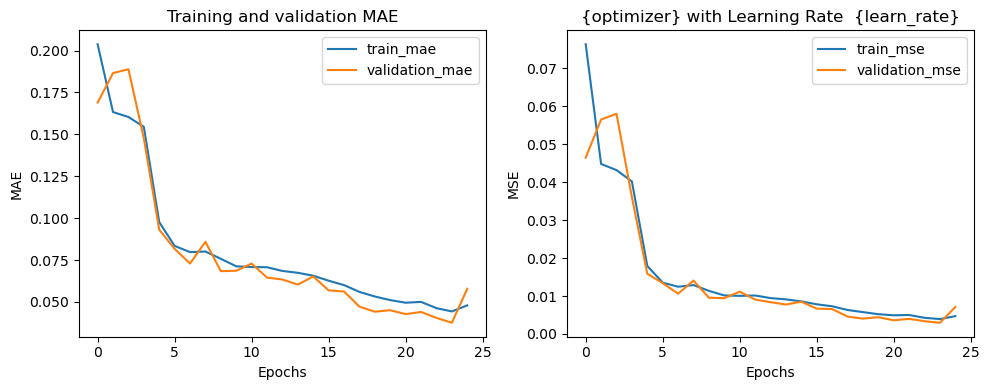

In [8]:
run_results(optimizer, 0.0001)

In [ ]:
# Save trained LSTM model
save_model_path = output_model_folder_path + "lstm_model.p"
pickle.dump(model, open(save_model_path, "wb"))

# Save dataset
save_data_path = output_data_folder_path + "dataset.p"
pickle.dump([data_train, labels_train], open(save_data_path, "wb"))

In [ ]:
# Loading saved LSTM model
output_data_folder_path = "Label/All/"
output_model_folder_path = "Model/"

load_model_path = output_model_folder_path + "lstm_model.p"
loaded_model = pickle.load(open(load_model_path, "rb"))

load_data_path = output_data_folder_path + "dataset.p"
dataset_X, dataset_y = pickle.load(open(load_data_path, "rb"))